# Проект

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Исследовательский анализ данных

### Библиотеки

In [1]:
!pip install pandas_profiling -q
!pip install catboost
#Загрузка необходимых библиотек
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import seaborn as sns
import numpy as np
import catboost as cb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder 
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit,  cross_val_score
from sklearn.manifold import TSNE

RANDOM_STATE = 250722

pd.set_option('display.max_columns', None)


### Исследование данных

In [2]:
# данные
phone = pd.read_csv('/datasets/final_provider/phone.csv')
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [3]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [4]:
phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

<div class="alert alert-info">
    
<font size="3"><b> Описание:
    
    customerID: идентификатор клиента;
    MultipleLines: наличие нескольких телефонных линий у клиента.
</b></font>
    
</div>

In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

<div class="alert alert-info">
    
<font size="3"><b> Описание:
    
    customerID: идентификатор клиента;
    BeginDate: дата подключения к оператору;
    EndDate: дата прекращения договора;
    Type: тип договора (с помесячной оплатой, годовой или двухгодовой);
    Paperlessbilling: электронный счет;
    PaymentMethod: метод оплаты;
    MonthlyCharges: ежемесячная плата за услуги;
    TotalCharges: общая плата за услуги за все время.
</b></font>
    
</div>

In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

<div class="alert alert-info">
    
<font size="3"><b> Описание:
    
    customerID: идентификатор клиента;
    gender: пол;
    SeniorCitizen: является ли клиент пенсионером;
    Partner: наличие супруга/супруги;
    Dependents: наличие иждивенцев.
</b></font>
    
</div>

In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [11]:
# объединяем по идентификатору
final_provider = personal.set_index('customerID').join(contract.set_index('customerID'))
final_provider = final_provider.join(phone.set_index('customerID'))
final_provider = final_provider.join(internet.set_index('customerID'))
final_provider.head()

gender  SeniorCitizen Partner Dependents   BeginDate  \
customerID                                                         
7590-VHVEG  Female              0     Yes         No  2020-01-01   
5575-GNVDE    Male              0      No         No  2017-04-01   
3668-QPYBK    Male              0      No         No  2019-10-01   
7795-CFOCW    Male              0      No         No  2016-05-01   
9237-HQITU  Female              0      No         No  2019-09-01   

                        EndDate            Type PaperlessBilling  \
customerID                                                         
7590-VHVEG                   No  Month-to-month              Yes   
5575-GNVDE                   No        One year               No   
3668-QPYBK  2019-12-01 00:00:00  Month-to-month              Yes   
7795-CFOCW                   No        One year               No   
9237-HQITU  2019-11-01 00:00:00  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges TotalCharges  \
customerID                                                           
7590-VHVEG           Electronic check           29.85        29.85   
5575-GNVDE               Mailed check           56.95       1889.5   
3668-QPYBK               Mailed check           53.85       108.15   
7795-CFOCW  Bank transfer (automatic)           42.30      1840.75   
9237-HQITU           Electronic check           70.70       151.65   

           MultipleLines InternetService OnlineSecurity OnlineBackup  \
customerID                                                             
7590-VHVEG           NaN             DSL             No          Yes   
5575-GNVDE            No             DSL            Yes           No   
3668-QPYBK            No             DSL            Yes          Yes   
7795-CFOCW           NaN             DSL            Yes           No   
9237-HQITU            No     Fiber optic             No           No   

           DeviceProtection TechSupport StreamingTV StreamingMovies  
customerID                                                           
7590-VHVEG               No          No          No              No  
5575-GNVDE              Yes          No          No              No  
3668-QPYBK               No          No          No              No  
7795-CFOCW              Yes         Yes          No              No  
9237-HQITU               No          No          No              No

In [12]:
final_provider.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   BeginDate         7043 non-null   object 
 5   EndDate           7043 non-null   object 
 6   Type              7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7043 non-null   object 
 11  MultipleLines     6361 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null 

<AxesSubplot:ylabel='customerID'>

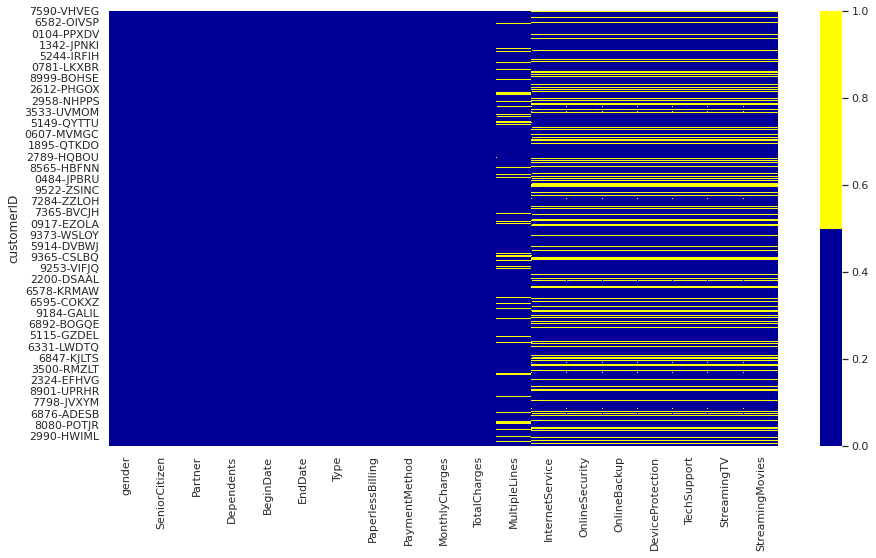

In [13]:
# смотрим пропуски
cols = final_provider.columns
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(final_provider[cols].isnull(), cmap=sns.color_palette(colours))

In [14]:
# так как в первоначальных таблицах пропусков не было заменяем появившиеся при объединении пропуски на No
empty_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in empty_columns:
    final_provider[col].fillna('No',inplace = True)


In [15]:
final_provider.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   BeginDate         7043 non-null   object 
 5   EndDate           7043 non-null   object 
 6   Type              7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7043 non-null   object 
 11  MultipleLines     7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null 

In [16]:
# смотрим почему не числа
final_provider['TotalCharges'].value_counts()

20.2       11
           11
19.75       9
20.05       8
19.9        8
           ..
4447.55     1
391.7       1
4456.65     1
970.55      1
2696.55     1
Name: TotalCharges, Length: 6531, dtype: int64

In [17]:
# заполним пробелы в TotalCharges значениями за месяц
final_provider.loc[final_provider['TotalCharges'] == ' ', 'TotalCharges'] = final_provider['MonthlyCharges']
final_provider['TotalCharges']  = final_provider['TotalCharges'] .astype('float')

In [18]:
# отчет по всем данным
profile = ProfileReport(final_provider)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
# срез по ушедшим
final_provider_end = final_provider.query('EndDate != "No"')

In [20]:
final_provider_end.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1869 entries, 3668-QPYBK to 8361-LTMKD
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            1869 non-null   object 
 1   SeniorCitizen     1869 non-null   int64  
 2   Partner           1869 non-null   object 
 3   Dependents        1869 non-null   object 
 4   BeginDate         1869 non-null   object 
 5   EndDate           1869 non-null   object 
 6   Type              1869 non-null   object 
 7   PaperlessBilling  1869 non-null   object 
 8   PaymentMethod     1869 non-null   object 
 9   MonthlyCharges    1869 non-null   float64
 10  TotalCharges      1869 non-null   float64
 11  MultipleLines     1869 non-null   object 
 12  InternetService   1869 non-null   object 
 13  OnlineSecurity    1869 non-null   object 
 14  OnlineBackup      1869 non-null   object 
 15  DeviceProtection  1869 non-null   object 
 16  TechSupport       1869 non-null 

In [21]:
# отчет по ушедшим
profile1 = ProfileReport(final_provider_end)
profile1

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<div class="alert alert-info">
    
<font size="3"><b> Из отчетов pandas_profiling видно, что:
    
        - отток начался с 01.10.2019;
        - увеличилось соотношение пенсионеров с 16,2 % по всем данным до 25,5 % среди ушедших;
        - увеличилось соотношение неженатых с 51,7 % по всем данным до 64,2 % среди ушедших;
        - увеличилось соотношение не имеющих иждивенцев с 70,0 % по всем данным до 82,6 % среди ушедших;
        - увеличилось соотношение с помесячной оплатой с 55,0 % по всем данным до 88,6 % среди ушедших;
        - увеличилось соотношение с оплатой по безналичному расчету с 59,2 % по всем данным до 74,9 % среди ушедших;
        - увеличилось соотношение с оплатой по электронному чеку с 33,6 % по всем данным до 57,3 % среди ушедших;
        - среди ушедших больше пользователей интернета и соответственно у кого есть оптоволоконный кабель;
        - увеличилось соотношение без тех поддержки с 71,0 % по всем данным до 83,4 % среди ушедших;
        - дополнительные услуги нпрактически не влияют на ушедших.
    
  
</b></font>
    
</div>

<div class="alert alert-info">
    
<font size="3"><b> Посмотрим пришедших за период, когда начался отток.
  
</b></font>
    
</div>

In [22]:
final_provider['BeginDate']=pd.to_datetime(final_provider['BeginDate'],format = '%Y-%m-%d')

In [23]:
# срез по пришедшим 01.10.2019
final_provider_come = final_provider.query('BeginDate >=  "2019-10-01"')

In [24]:
final_provider_come.info()

<class 'pandas.core.frame.DataFrame'>
Index: 938 entries, 7590-VHVEG to 6894-LFHLY
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            938 non-null    object        
 1   SeniorCitizen     938 non-null    int64         
 2   Partner           938 non-null    object        
 3   Dependents        938 non-null    object        
 4   BeginDate         938 non-null    datetime64[ns]
 5   EndDate           938 non-null    object        
 6   Type              938 non-null    object        
 7   PaperlessBilling  938 non-null    object        
 8   PaymentMethod     938 non-null    object        
 9   MonthlyCharges    938 non-null    float64       
 10  TotalCharges      938 non-null    float64       
 11  MultipleLines     938 non-null    object        
 12  InternetService   938 non-null    object        
 13  OnlineSecurity    938 non-null    object        
 14  OnlineBackup   

<AxesSubplot:>

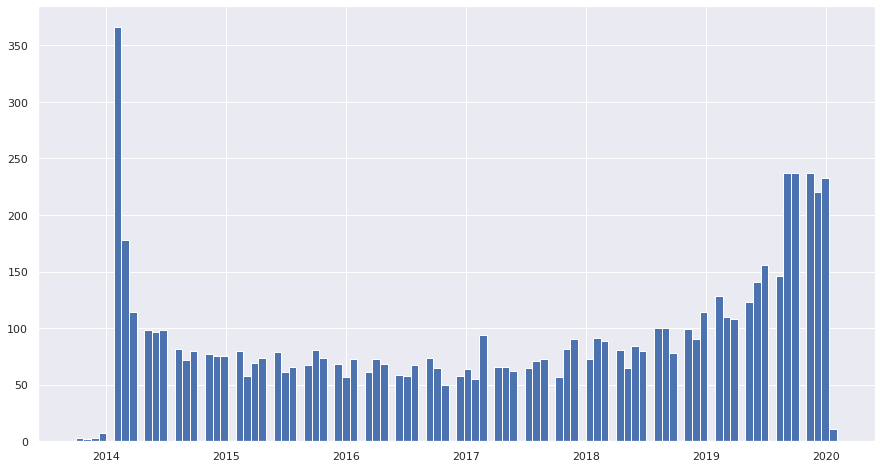

In [25]:
# пришедшие за весь период
final_provider['BeginDate'].hist(bins=100)

<AxesSubplot:>

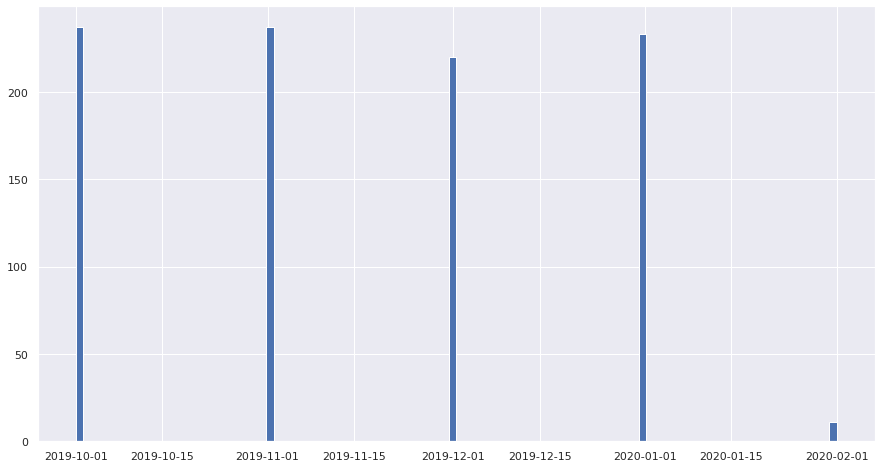

In [26]:
# пришедшие c 01.10.2019
final_provider_come['BeginDate'].hist(bins=100)

<AxesSubplot:>

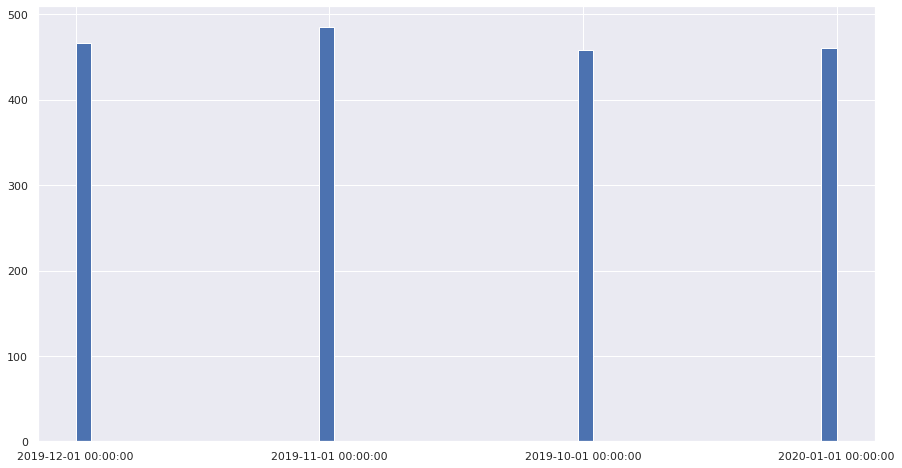

In [27]:
# пришедшие за весь период
final_provider_end['EndDate'].hist(bins=50)

### Выводы

<div class="alert alert-info">
    
<font size="3"><b> Из предварительного анализа видно, что оператор связи «Ниединогоразрыва.ком» имел помимо всплеска в 
начале 2014 года постоянную прибавку в числе клиентов. С середины 2018 года начался прирост клиентов, который постепенно 
хуже чем нивелировался с октября 2019 года оттоком старых клиентов. В конечном счете с октября 2019 года число 
пришедших клиентов составило 938, а ушедших 1869. То есть клиенты исчезают.
Если предположительно резюмировать предварительные исследования, то можно сказать, что среди ушедших увеличилось соотношение,
получающих периодический доход - пенсионеры, те, кто не могут позволить себе купить годовой абонемент, также 
не могущие позволить установить себе автоматическую оплату. То есть, предположительно стала напрягать сумма платежей.
Можно предположить, что вся задача маркетингого отдела состояла в том, чтобы делать раз в год один и тот же заказ на рекламу
и получать стабильный рост клиентов. Скорее всего такое было возможно за счет отсутствия конкуренции и низких цен оператора.

  
</b></font>
    
</div>

## Подготовка данных

<div class="alert alert-info">
    
<font size="3"><b> Необходимо:
    
        - создать столбец целевого признака;
        - перевести столбец EndDate в формат datetime64;
        - создать признак по времени пользованиями услугами компании;
        - столбцы с 'Yes' и 'No' и двумя категориями заменим бинарной логикой;
        - удалить ненужные столбцы.
  
</b></font>
    
</div>

In [28]:
# столбец целевого признака
final_provider['Goal'] = 1
final_provider.loc[final_provider['EndDate'] == 'No', 'Goal'] = 0

In [29]:
# крайняя дата
final_provider['BeginDate'].max()

Timestamp('2020-02-01 00:00:00')

In [30]:
# заменим No на крайнюю дату
final_provider['EndDate'] = final_provider['EndDate'].replace(['No'], ['2020-02-01'])

In [31]:
# формат
final_provider['EndDate']=pd.to_datetime(final_provider['EndDate'],format = '%Y-%m-%d')

In [32]:
# время пользования услугами
final_provider['DaysContract'] = (final_provider['EndDate'] - final_provider['BeginDate']).dt.days

In [33]:
# заменим бинарной логикой
binary_columns = ['Partner', 'Dependents', 'PaperlessBilling', 'MultipleLines', 'OnlineSecurity',
                  'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

final_provider['gender'] = pd.Series(np.where(final_provider['gender'].values == 'Male', 1, 0),final_provider.index)

for col in binary_columns:
    final_provider[col] = pd.Series(np.where(final_provider[col].values == 'Yes', 1, 0),final_provider.index)

In [34]:
# кодирование
final_provider_full = pd.get_dummies(final_provider, drop_first = True)

In [35]:
final_provider_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   gender                                 7043 non-null   int64         
 1   SeniorCitizen                          7043 non-null   int64         
 2   Partner                                7043 non-null   int64         
 3   Dependents                             7043 non-null   int64         
 4   BeginDate                              7043 non-null   datetime64[ns]
 5   EndDate                                7043 non-null   datetime64[ns]
 6   PaperlessBilling                       7043 non-null   int64         
 7   MonthlyCharges                         7043 non-null   float64       
 8   TotalCharges                           7043 non-null   float64       
 9   MultipleLines                          7043 non-null 

In [36]:
# удалим столбцы с датой, у нас есть DaysContract
final_provider_full.drop(['EndDate', 'BeginDate'], axis = 1, inplace = True)

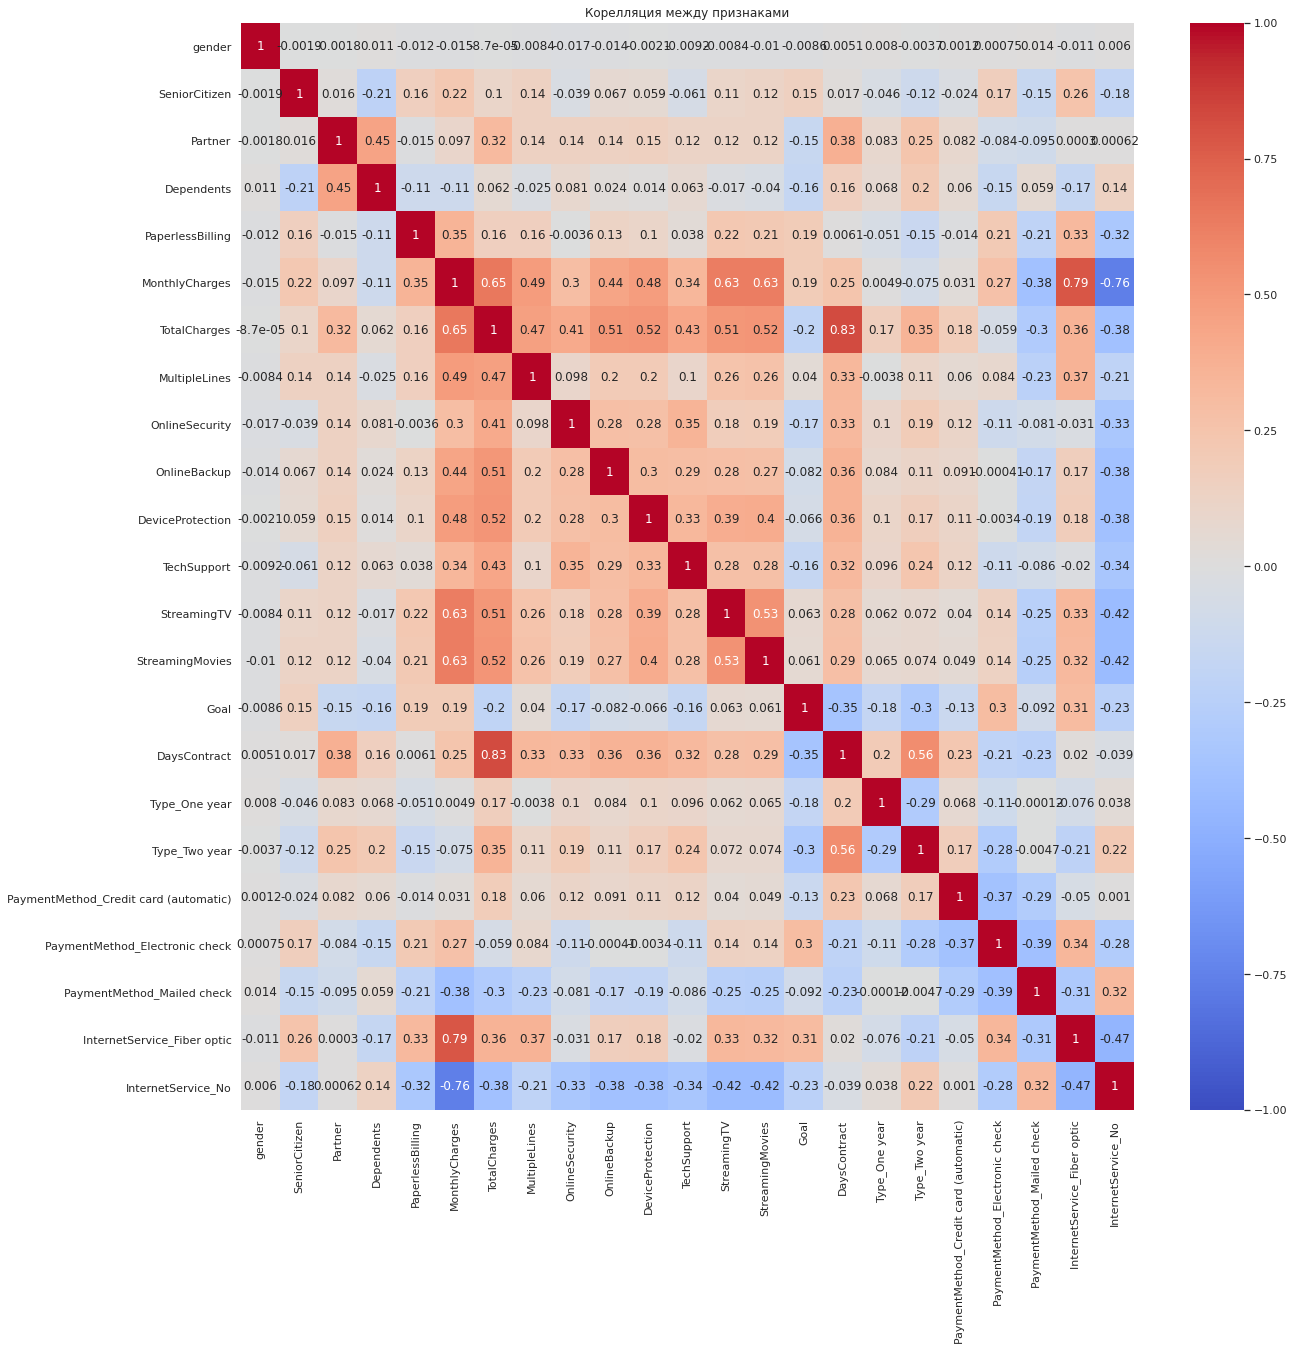

In [37]:
# смотрим корелляцию между признаками
plt.figure(figsize=(20, 20))
sns.heatmap(final_provider_full.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center= 0,  cmap='coolwarm')
plt.title('Корелляция между признаками')
plt.show()

In [38]:
# так как есть проблема мультиколлинеарности между DaysContract и TotalCharges 
final_provider_full.drop(['TotalCharges'], axis = 1, inplace = True)

In [39]:
# корелляция по целевому
correlations = final_provider_full.corr()['Goal'].sort_values()
correlations

DaysContract                            -0.352673
Type_Two year                           -0.302253
InternetService_No                      -0.227890
Type_One year                           -0.177820
OnlineSecurity                          -0.171226
TechSupport                             -0.164674
Dependents                              -0.164221
Partner                                 -0.150448
PaymentMethod_Credit card (automatic)   -0.134302
PaymentMethod_Mailed check              -0.091683
OnlineBackup                            -0.082255
DeviceProtection                        -0.066160
gender                                  -0.008612
MultipleLines                            0.040102
StreamingMovies                          0.061382
StreamingTV                              0.063228
SeniorCitizen                            0.150889
PaperlessBilling                         0.191825
MonthlyCharges                           0.193356
PaymentMethod_Electronic check           0.301919


In [40]:
# удалим несущественный признак пола
final_provider_full = final_provider_full.drop(['gender'], axis=1)

<div class="alert alert-info">
    
<font size="3"><b> После подготовки данных и анализа убедились в отсутствии утечки у целевого признака Goal.

  
</b></font>
    
</div>

## Моделирование

### Баланс

In [41]:
final_provider_full['Goal'].value_counts()

0    5174
1    1869
Name: Goal, dtype: int64

<div class="alert alert-info">
    
<font size="3"><b> Есть дисбаланс. нужно учесть при моделировании.

  
</b></font>
    
</div>

### Разбиваем данные

In [42]:
train, test = train_test_split(final_provider_full, test_size = 0.2, random_state = RANDOM_STATE)
x_train = train.drop('Goal', axis = 1)
x_test = test.drop('Goal', axis = 1)

y_train = train['Goal']
y_test = test['Goal']

### Масштабирование

In [43]:
scaler = StandardScaler()
numeric = ['MonthlyCharges', 'DaysContract']
scaler.fit(x_train[numeric])
x_train[numeric] = scaler.transform(x_train[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])
x_train.head()

SeniorCitizen  Partner  Dependents  PaperlessBilling  \
customerID                                                         
9975-GPKZU              0        1           1                 0   
5461-QKNTN              1        1           0                 1   
8766-PAFNE              0        1           0                 1   
0407-BDJKB              0        1           0                 1   
5515-IDEJJ              0        1           1                 0   

            MonthlyCharges  MultipleLines  OnlineSecurity  OnlineBackup  \
customerID                                                                
9975-GPKZU       -1.486564              0               0             0   
5461-QKNTN        0.987190              1               0             1   
8766-PAFNE        0.482816              0               0             1   
0407-BDJKB        1.035304              1               0             1   
5515-IDEJJ       -1.481587              0               0             0   

            DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
customerID                                                                
9975-GPKZU                 0            0            0                0   
5461-QKNTN                 0            1            1                0   
8766-PAFNE                 1            1            1                1   
0407-BDJKB                 1            0            1                0   
5515-IDEJJ                 0            0            0                0   

            DaysContract  Type_One year  Type_Two year  \
customerID                                               
9975-GPKZU      0.560311              0              1   
5461-QKNTN      0.438162              0              0   
8766-PAFNE      1.583147              0              1   
0407-BDJKB      1.130790              0              0   
5515-IDEJJ     -1.278645              0              0   

            PaymentMethod_Credit card (automatic)  \
customerID                                          
9975-GPKZU                                      1   
5461-QKNTN                                      0   
8766-PAFNE                                      1   
0407-BDJKB                                      0   
5515-IDEJJ                                      0   

            PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
customerID                                                               
9975-GPKZU                               0                           0   
5461-QKNTN                               1                           0   
8766-PAFNE                               0                           0   
0407-BDJKB                               1                           0   
5515-IDEJJ                               0                           1   

            InternetService_Fiber optic  InternetService_No  
customerID                                                   
9975-GPKZU                            0                   1  
5461-QKNTN                            1                   0  
8766-PAFNE                            0                   0  
0407-BDJKB                            1                   0  
5515-IDEJJ                            0                   1

### Случайный лес

In [44]:
%%time

# модель
RFC = RandomForestClassifier(random_state = RANDOM_STATE, criterion = 'entropy', class_weight='balanced', n_jobs=-1)
#словарь 
RFC_parametrs = {'n_estimators': range(10, 30, 5),
                     'max_depth': range(1, 10, 2),
                     'min_samples_leaf': range(2, 10, 2),
                     'min_samples_split': range(2, 10, 2)}

RFC_grid = GridSearchCV(RFC, RFC_parametrs, scoring='roc_auc', cv=4)
RFC_grid.fit(x_train, y_train)

CPU times: user 1min 2s, sys: 499 ms, total: 1min 2s
Wall time: 1min 3s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy', n_jobs=-1,
                                              random_state=250722),
             param_grid={'max_depth': range(1, 10, 2),
                         'min_samples_leaf': range(2, 10, 2),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 30, 5)},
             scoring='roc_auc')

In [45]:
# обучение
RFC.fit(x_train, y_train)
RFC_cv_score = cross_val_score(RFC, x_train, y_train, scoring='roc_auc', cv=4).mean()
print('Среднее качество Случайного леса на кросс-валидации по auc_roc:', RFC_cv_score)

Среднее качество Случайного леса на кросс-валидации по auc_roc: 0.8361211993519233


In [46]:
%%time
# лучшее значение параметров
RFC_params = RFC_grid.best_params_
RFC_score = RFC_grid.score(x_train, y_train)
print('Лучшее значение гиперпараметров: ', RFC_params)
print('Лучшее значение auc_roc: ', RFC_score) 

Лучшее значение гиперпараметров:  {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 25}
Лучшее значение auc_roc:  0.8820753935796586
CPU times: user 22.9 ms, sys: 0 ns, total: 22.9 ms
Wall time: 31.8 ms


In [47]:
%%time
# проверка на тестовой
RFC_test_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced', criterion = 'entropy',
                                     max_depth=RFC_params['max_depth'],
                                     min_samples_leaf = RFC_params['min_samples_leaf'],
                                     min_samples_split = RFC_params['min_samples_split'],
                                     n_estimators = RFC_params['n_estimators'])

RFC_test_model.fit(x_train, y_train)
probabilities_valid = RFC_test_model.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_valid)
acc = RFC_test_model.score(x_test, y_test)
print('AUC-ROC модели случайный лес:', auc_roc)
print('Accuracy модели случайный лес:', acc)

AUC-ROC модели случайный лес: 0.8636343248534355
Accuracy модели случайный лес: 0.772888573456352
CPU times: user 93.6 ms, sys: 0 ns, total: 93.6 ms
Wall time: 98.2 ms


### Логистическая регрессия

In [48]:
%%time

# модель
LR = LogisticRegression(fit_intercept=True, 
                      n_jobs=None,
                      class_weight='balanced',
                      solver='lbfgs',  
                      random_state=RANDOM_STATE
                     )
# словарь
hyperparams = {'C': [0.1, 1, 10]}

# обучение
LR_grid = GridSearchCV(LR, hyperparams, scoring='roc_auc', cv=4)
LR_grid.fit(x_train, y_train)

# auc_roc с помощью кросс-валидации
LR.fit(x_train, y_train)
LR_cv_score = cross_val_score(LR ,x_train, y_train, scoring='roc_auc', cv=4).mean()
print('Среднее качество Логистической регрессии на кросс-валидации:', LR_cv_score)

Среднее качество Логистической регрессии на кросс-валидации: 0.840942649242728
CPU times: user 2.2 s, sys: 6.64 s, total: 8.84 s
Wall time: 8.79 s


In [49]:
%%time

LR_params = LR_grid.best_params_
LR_score = LR_grid.score(x_train, y_train)
print('Лучшее значение гиперпараметров: ', LR_params)
print('Лучшее значение auc_roc: ', LR_score)

Лучшее значение гиперпараметров:  {'C': 10}
Лучшее значение auc_roc:  0.8445955864796366
CPU times: user 7.85 ms, sys: 31.1 ms, total: 39 ms
Wall time: 7.15 ms


In [50]:
%%time
# проверка на тестовой
LR_test_model = LogisticRegression(fit_intercept=True,
                                class_weight='balanced',
                                random_state=RANDOM_STATE,
                                solver='lbfgs',
                                C=LR_params['C']
                               )

LR_test_model.fit(x_train, y_train)
probabilities_valid = LR_test_model.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_valid)
acc = LR_test_model.score(x_test, y_test)
print('AUC-ROC модели логистическая регрессия:', auc_roc)
print('Accuracy модели логистическая регрессия:', acc)

AUC-ROC модели логистическая регрессия: 0.8527059686449578
Accuracy модели логистическая регрессия: 0.7558552164655784
CPU times: user 165 ms, sys: 202 ms, total: 367 ms
Wall time: 307 ms


### CatBoost

In [51]:
%%time

# модель 
CB = cb.CatBoostClassifier(class_weights=[1, 5174/1869], 
                           verbose=10, 
                           loss_function="Logloss",
                           iterations=1000,
                           random_state=RANDOM_STATE
                          )
#словарь
CB_parametrs = {'learning_rate': [0.02, 0.3],
                'depth': [4, 6, 8]
               }

CB_grid = GridSearchCV(CB, CB_parametrs, scoring='roc_auc', cv=4)
CB_grid.fit(x_train, y_train, verbose=10)

# auc_roc с помощью кросс-валидации
CB.fit(x_train, y_train)
CB_cv_score = cross_val_score(CB ,x_train, y_train, scoring='roc_auc', cv=4).mean()
print('Среднее качество Catboost на кросс-валидации:', CB_cv_score)

0:	learn: 0.6848469	total: 47.7ms	remaining: 47.7s
10:	learn: 0.6180833	total: 58.3ms	remaining: 5.24s
20:	learn: 0.5799096	total: 68.6ms	remaining: 3.2s
30:	learn: 0.5514806	total: 79.1ms	remaining: 2.47s
40:	learn: 0.5319996	total: 89.9ms	remaining: 2.1s
50:	learn: 0.5187776	total: 101ms	remaining: 1.87s
60:	learn: 0.5075061	total: 111ms	remaining: 1.71s
70:	learn: 0.4994019	total: 122ms	remaining: 1.59s
80:	learn: 0.4923664	total: 132ms	remaining: 1.5s
90:	learn: 0.4869897	total: 143ms	remaining: 1.43s
100:	learn: 0.4819063	total: 154ms	remaining: 1.37s
110:	learn: 0.4781127	total: 164ms	remaining: 1.31s
120:	learn: 0.4751536	total: 174ms	remaining: 1.26s
130:	learn: 0.4717345	total: 185ms	remaining: 1.23s
140:	learn: 0.4694760	total: 196ms	remaining: 1.19s
150:	learn: 0.4664539	total: 208ms	remaining: 1.17s
160:	learn: 0.4644727	total: 219ms	remaining: 1.14s
170:	learn: 0.4614253	total: 229ms	remaining: 1.11s
180:	learn: 0.4595268	total: 240ms	remaining: 1.08s
190:	learn: 0.4573307

In [52]:
%%time

CB_params = CB_grid.best_params_
CB_score = CB_grid.score(x_train, y_train)
print('Лучшее значение гиперпараметров: ', CB_params)
print('Лучшее значение auc_roc: ', CB_score)

Лучшее значение гиперпараметров:  {'depth': 4, 'learning_rate': 0.3}
Лучшее значение auc_roc:  0.999264156012753
CPU times: user 12.2 ms, sys: 23 µs, total: 12.2 ms
Wall time: 10.8 ms


In [53]:
%%time

CB_test_model = cb.CatBoostClassifier(class_weights=[1, 5174/1869], 
                                      depth=CB_params['depth'],
                                      learning_rate=CB_params['learning_rate'],
                                      iterations=1000,
                                      random_state=RANDOM_STATE
                                     )
CB_test_model.fit(x_train, y_train, verbose=10)
probabilities_valid = CB_test_model.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_valid)
acc = CB_test_model.score(x_test, y_test)
print('AUC-ROC модели Catboost:', auc_roc)
print('Accuracy модели Catboost:', acc)

0:	learn: 0.5951782	total: 1.59ms	remaining: 1.59s
10:	learn: 0.4569295	total: 15.1ms	remaining: 1.36s
20:	learn: 0.4353383	total: 28.7ms	remaining: 1.34s
30:	learn: 0.4200937	total: 42.2ms	remaining: 1.32s
40:	learn: 0.3932804	total: 56.2ms	remaining: 1.31s
50:	learn: 0.3750476	total: 70.3ms	remaining: 1.31s
60:	learn: 0.3505432	total: 84.3ms	remaining: 1.3s
70:	learn: 0.3408005	total: 101ms	remaining: 1.32s
80:	learn: 0.3243649	total: 115ms	remaining: 1.3s
90:	learn: 0.3107121	total: 128ms	remaining: 1.28s
100:	learn: 0.2976494	total: 142ms	remaining: 1.26s
110:	learn: 0.2866300	total: 156ms	remaining: 1.25s
120:	learn: 0.2747229	total: 171ms	remaining: 1.24s
130:	learn: 0.2674717	total: 184ms	remaining: 1.22s
140:	learn: 0.2599906	total: 198ms	remaining: 1.21s
150:	learn: 0.2534091	total: 212ms	remaining: 1.19s
160:	learn: 0.2481370	total: 226ms	remaining: 1.18s
170:	learn: 0.2419662	total: 240ms	remaining: 1.16s
180:	learn: 0.2356916	total: 254ms	remaining: 1.15s
190:	learn: 0.2307

In [54]:
# таблица для удобства
data_metrics_final=[
    ['Случайный лес', '0.882', '0.836', '0.864', '0.773'],
    ['Логистическая регрессия', '0.844', '0.841', '0.853', '0.756'],
    ['Catboost', '0.999', '0.898', '0.927', '0.875'],
    ]
columns=['Модель', 'Лучшее значение auc_roc', 'Среднее значение auc_roc на кросс-валидации',
         'Значение auc_roc на тестовой модели', 'Accuracy модели']
results_metrics = pd.DataFrame(data=data_metrics_final, columns=columns)
display(results_metrics) # Таблица с результатами

Модель Лучшее значение auc_roc  \
0            Случайный лес                   0.882   
1  Логистическая регрессия                   0.844   
2                 Catboost                   0.999   

  Среднее значение auc_roc на кросс-валидации  \
0                                       0.836   
1                                       0.841   
2                                       0.898   

  Значение auc_roc на тестовой модели Accuracy модели  
0                               0.864           0.773  
1                               0.853           0.756  
2                               0.927           0.875

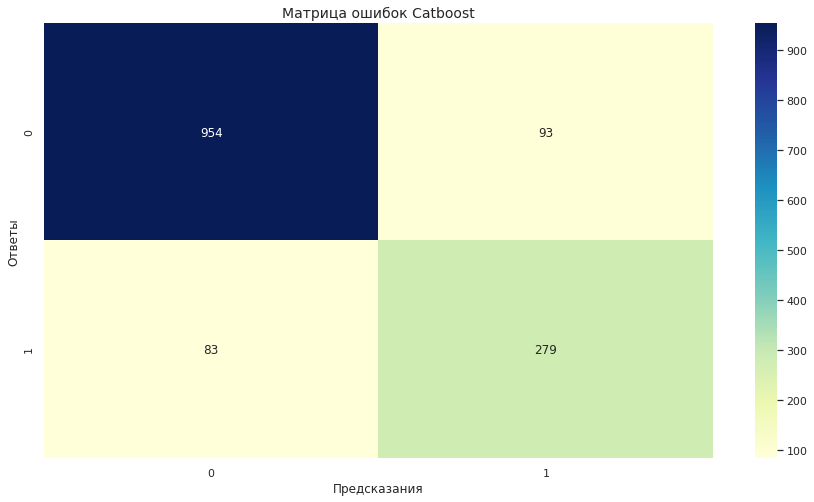

In [55]:
# матрица ошибок
df_CB = pd.DataFrame(confusion_matrix(y_test, CB_test_model.predict(x_test)))

df_list = [df_CB]
sns.set(font_scale=1)

sns.heatmap(df_CB, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок ' + 'Catboost', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

<div class="alert alert-info">
    
<font size="3"><b> По заданной метрике мы теряем в результате предсказаний каждого четвертого клиента из решивших уйти.
Модель довольно точно предсказывает оставшихся.

</b></font>
    
</div>

### Важность признаков

feature  importance
0                            DaysContract   59.510716
1                          MonthlyCharges   17.211947
2                           Type_Two year    4.007344
3                           Type_One year    1.672552
4          PaymentMethod_Electronic check    1.543397
5                        PaperlessBilling    1.498268
6                             TechSupport    1.456256
7             InternetService_Fiber optic    1.391791
8                              Dependents    1.241740
9                      InternetService_No    1.088558
10                           OnlineBackup    1.084074
11                        StreamingMovies    1.080971
12                                Partner    1.059007
13             PaymentMethod_Mailed check    1.047045
14                          SeniorCitizen    1.040002
15                         OnlineSecurity    0.977691
16                          MultipleLines    0.894982
17                       DeviceProtection    0.780243
18  PaymentMethod_Credit card (automatic)    0.739299
19                            StreamingTV    0.674117

<AxesSubplot:xlabel='importance', ylabel='feature'>

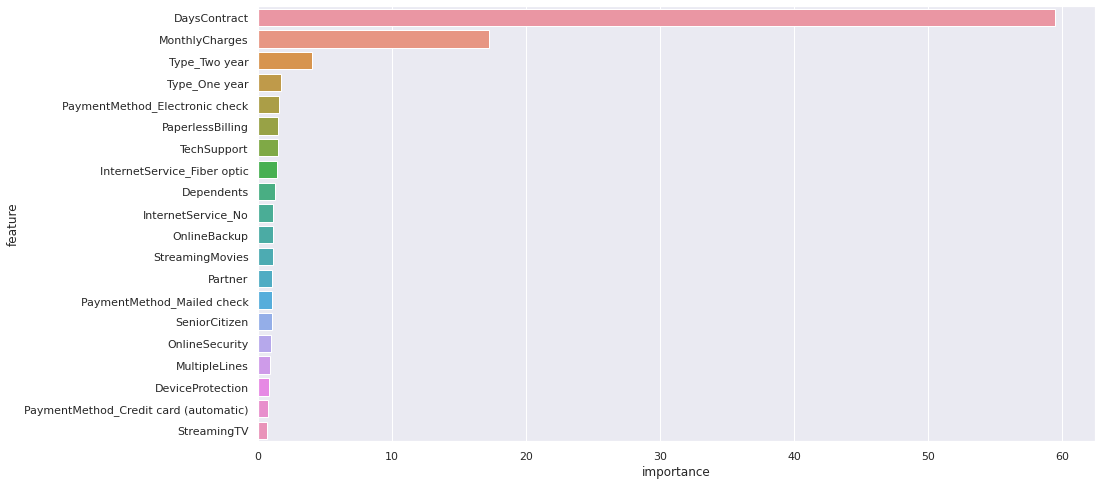

In [56]:
# отобразим важность признаков на лучшей модели Catboost
importances = CB_test_model.feature_importances_
feature_list = list(x_train.columns)
feature_results = pd.DataFrame({'feature': feature_list, 'importance': importances})
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)
display(feature_results)

import seaborn as sns
sns.barplot(x = 'importance', y = 'feature', data=feature_results)

<div class="alert alert-info">
    
<font size="3"><b> Самые важные признаки - длительность контракта и ежемесячные платежи.

</b></font>
    
</div>

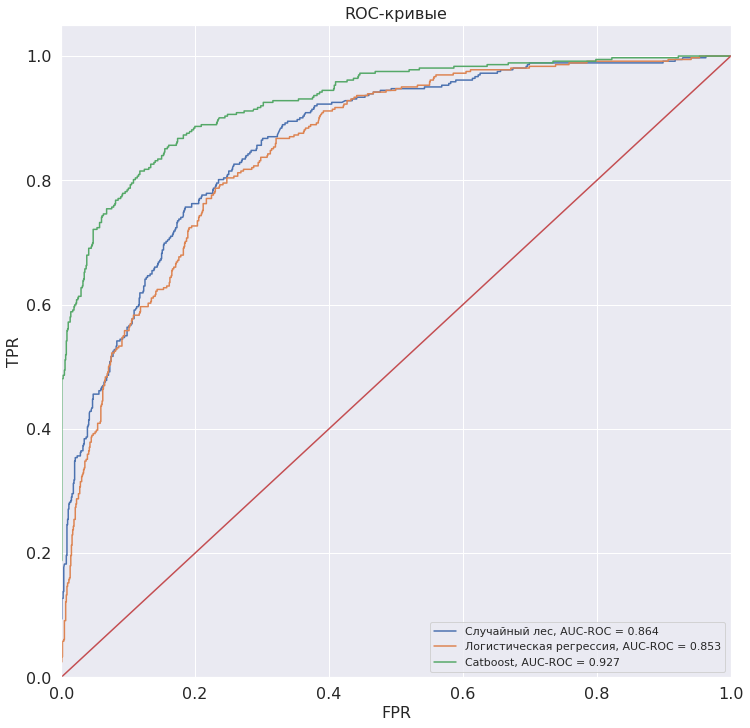

In [57]:
# построим кривые ROC кривые
fpr1, tpr1, thresholds1 = roc_curve(y_test, RFC_test_model.predict_proba(x_test)[:,1], pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, LR_test_model.predict_proba(x_test)[:,1], pos_label=1)
fpr3, tpr3, thresholds3 = roc_curve(y_test, CB_test_model.predict_proba(x_test)[:,1], pos_label=1)

auc_RFC = roc_auc_score(y_test, RFC_test_model.predict_proba(x_test)[:,1])
auc_LR = roc_auc_score(y_test, LR_test_model.predict_proba(x_test)[:,1])
auc_CB = roc_auc_score(y_test, CB_test_model.predict_proba(x_test)[:,1])

fig, ax = plt.subplots(figsize=(12,12))
ax.plot(fpr1, tpr1, label= 'Случайный лес, AUC-ROC = %.3f' %auc_RFC)
ax.plot(fpr2, tpr2, label= 'Логистическая регрессия, AUC-ROC = %.3f' %auc_LR)
ax.plot(fpr3, tpr3, label= 'Catboost, AUC-ROC = %.3f' %auc_CB)

plt.title('ROC-кривые', fontsize=16)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1])
plt.xlim([0.0, 1.0])
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.ylim([0.0, 1.05])
plt.tick_params(which='major', labelsize=16)
plt.show()

<div class="alert alert-info">
    
<font size="3"><b> Посмотрим на примере обучающих данных t-SNE представление данных как отображение из 
многомерного признакового пространства на плоскость, чтоб точки, которые были далеко друг от друга, 
на плоскости тоже оказались удаленными, а близкие точки – также отобразились на близкие. 

</b></font>
    
</div>

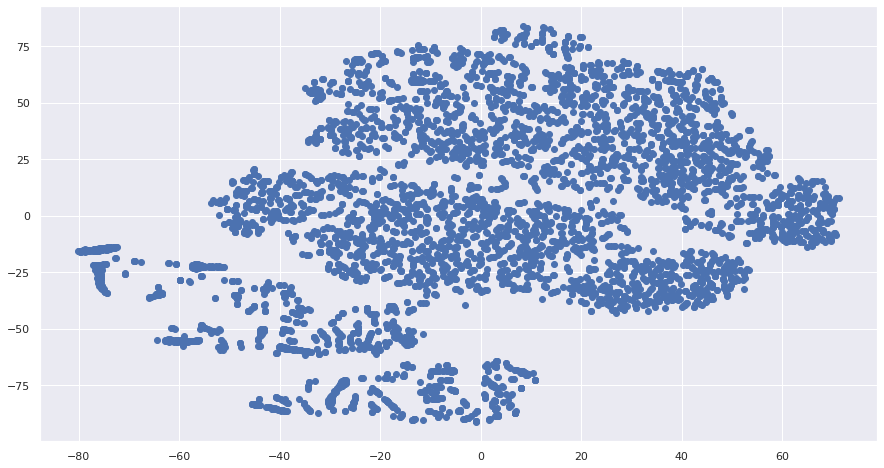

In [58]:
tsne = TSNE(random_state=RANDOM_STATE)
tsne_representation = tsne.fit_transform(x_train)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1]);

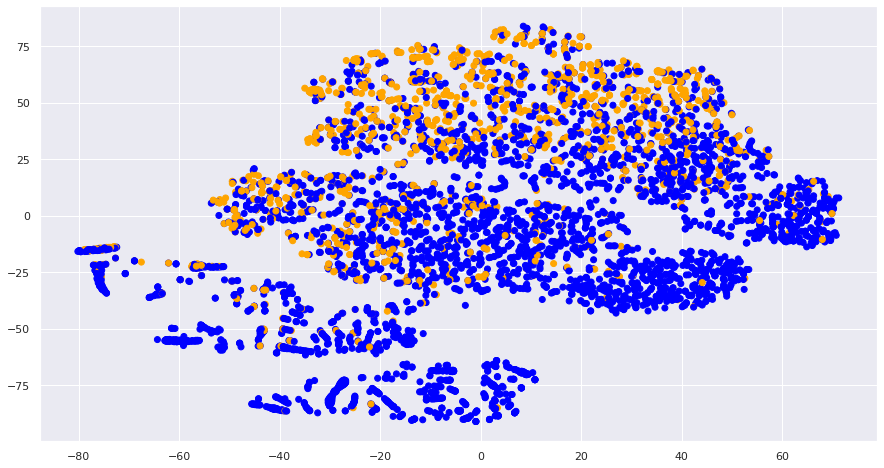

In [59]:
# выделим оранжевым ушедших
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1],
            c=y_train.map({0: 'blue', 1: 'orange'}));

<div class="alert alert-info">
    
<font size="3"><b> Видно, что основная масса ушедших клиентов расположилась в верхней и центральной части распределения данных.

</b></font>
    
</div>

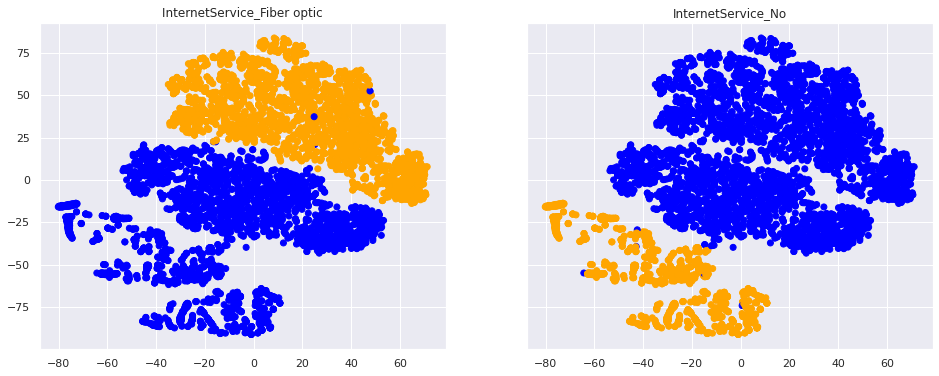

In [60]:
# выделим оранжевым положительные ответы в соответствующих признаках
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))

axes[0].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['InternetService_Fiber optic'].map({0 : 'blue', 1 : 'orange'}));
axes[1].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['InternetService_No'].map({ 0 : 'blue', 1 : 'orange'}));
axes[0].set_title('InternetService_Fiber optic');
axes[1].set_title('InternetService_No');

<div class="alert alert-info">
    
<font size="3"><b> Как можно убедиться, три области соответствуют трем видам услуг - без интернета, оптоволокно, DSL.
    Последний признак исчез после кодирования. Видно малое количество ушедших пользующихся услугами только телефона. Большинство ушедших по оптоволокну. Посмотрим оставшиеся признаки в направлении убывания важности.

</b></font>
    
</div>

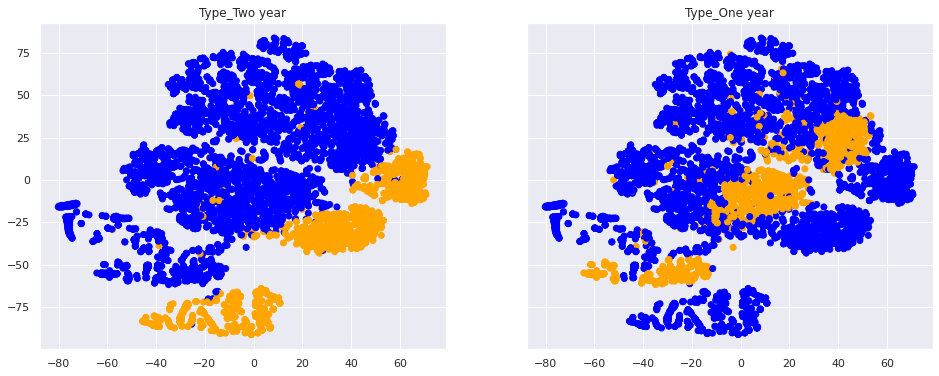

In [61]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
axes[0].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['Type_Two year'].map({0 : 'blue', 1 : 'orange'}));
axes[1].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['Type_One year'].map({0 : 'blue', 1 : 'orange'}));
axes[0].set_title('Type_Two year');
axes[1].set_title('Type_One year');


<div class="alert alert-info">
    
<font size="3"><b> Видно большое количество ушедших с помесячной оплатой, признака, который отсутствует.
</b></font>
    
</div>

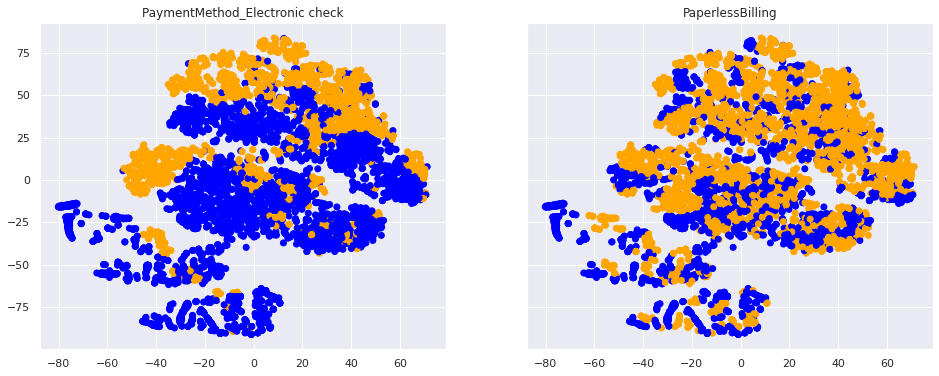

In [62]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
axes[0].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['PaymentMethod_Electronic check'].map({0 : 'blue', 1 : 'orange'}));
axes[1].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['PaperlessBilling'].map({0 : 'blue', 1 : 'orange'}));
axes[0].set_title('PaymentMethod_Electronic check');
axes[1].set_title('PaperlessBilling');


<div class="alert alert-info">
    
<font size="3"><b> Здесь трудно говорить о влиянии.
</b></font>
    
</div>

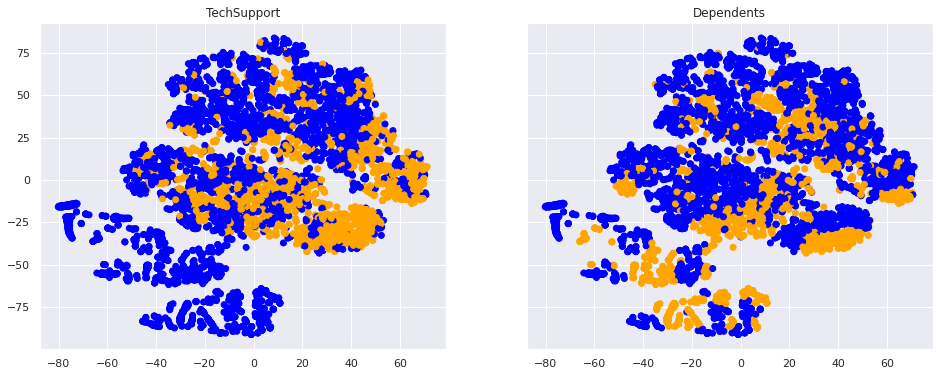

In [63]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
axes[0].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['TechSupport'].map({0 : 'blue', 1 : 'orange'}));
axes[1].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['Dependents'].map({0 : 'blue', 1 : 'orange'}));
axes[0].set_title('TechSupport');
axes[1].set_title('Dependents');

<div class="alert alert-info">
    
<font size="3"><b> Здесь можно предположить, что техническая поддержка на расположена в основном в области оставшихся клиентов.
Как и наличие иждивенцев.
</b></font>
    
</div>

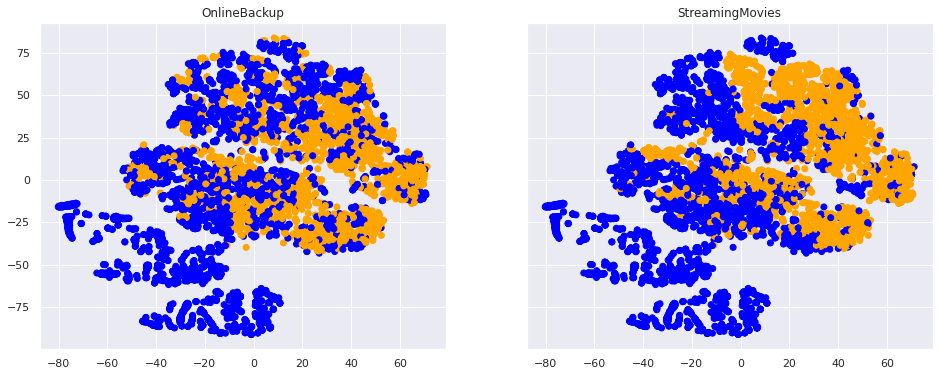

In [64]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
axes[0].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['OnlineBackup'].map({0 : 'blue', 1 : 'orange'}));
axes[1].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['StreamingMovies'].map({0 : 'blue', 1 : 'orange'}));
axes[0].set_title('OnlineBackup');
axes[1].set_title('StreamingMovies');

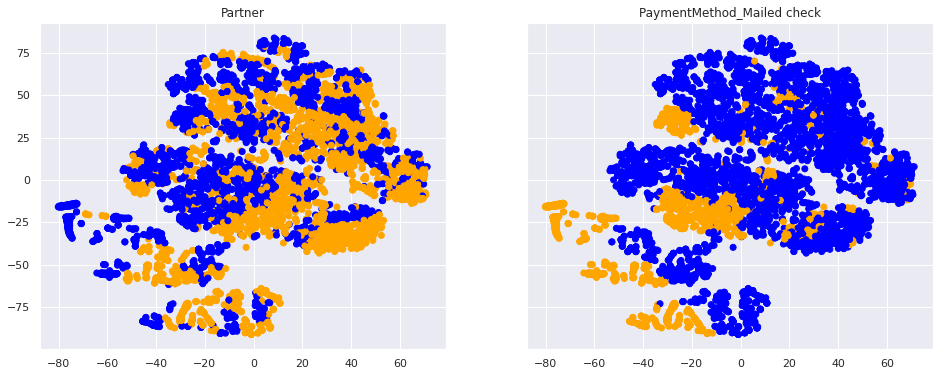

In [65]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
axes[0].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['Partner'].map({0 : 'blue', 1 : 'orange'}));
axes[1].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['PaymentMethod_Mailed check'].map({0 : 'blue', 1 : 'orange'}));
axes[0].set_title('Partner');
axes[1].set_title('PaymentMethod_Mailed check');

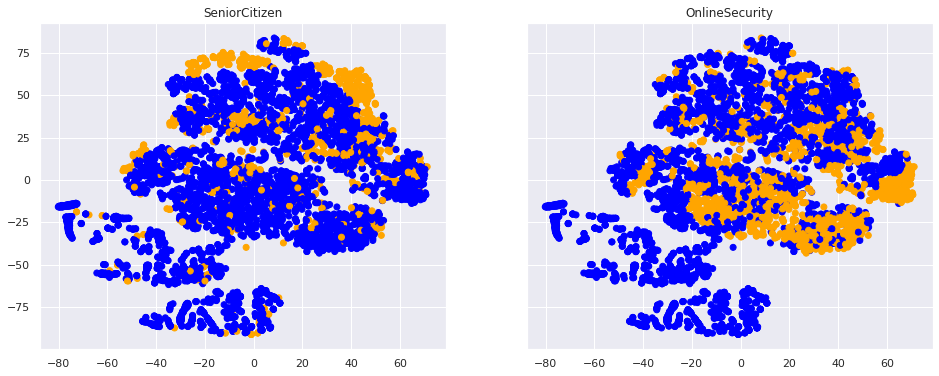

In [66]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
axes[0].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['SeniorCitizen'].map({0 : 'blue', 1 : 'orange'}));
axes[1].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['OnlineSecurity'].map({0 : 'blue', 1 : 'orange'}));
axes[0].set_title('SeniorCitizen');
axes[1].set_title('OnlineSecurity');

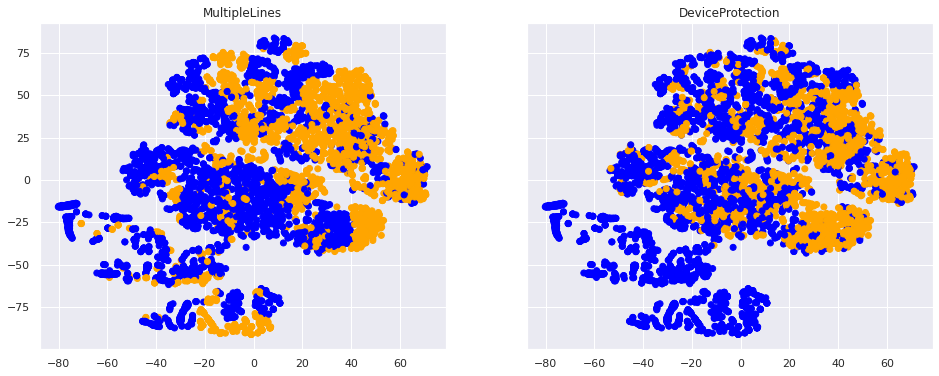

In [67]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
axes[0].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['MultipleLines'].map({0 : 'blue', 1 : 'orange'}));
axes[1].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['DeviceProtection'].map({0 : 'blue', 1 : 'orange'}));
axes[0].set_title('MultipleLines');
axes[1].set_title('DeviceProtection');

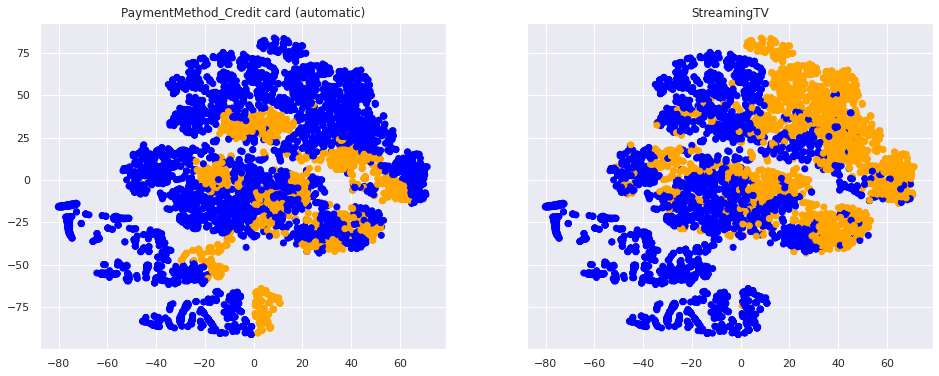

In [68]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
axes[0].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['PaymentMethod_Credit card (automatic)'].map({0 : 'blue', 1 : 'orange'}));
axes[1].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=x_train['StreamingTV'].map({0 : 'blue', 1 : 'orange'}));
axes[0].set_title('PaymentMethod_Credit card (automatic)');
axes[1].set_title('StreamingTV');

<div class="alert alert-info">
    
<font size="3"><b> По остальным признакам разброс.
</b></font>
    
</div>

### Выводы

<div class="alert alert-info">
    
<font size="3"><b> Провели подготовку данных. Выбрали три модели - случайный лес, логистическая регрессия, Catboost.
Провели разбивание данных на обучающие и тестовые выборки, провели обучение и перекрестную проверку моделей. В конце 
проверили модели на тестовой выборке. Лучший результат на тестовой показала модель Catboost c результатом 0.927. Задача решена.
Наибольшее влияние имеет признак длительность контракта.Можно было бы констатировать, что ушли преимущественно клиенты,
для которых важна сумма оплаты, так как с годовой и с двухгодовой остались, но период оттока слишком мал, чтобы можно было это
с уверенностью утверждать. Большинство ушедших клиентов с оптоволокном и помесячной оплатой. Трудно говорить о влиянии других
признаков, так техническая поддержка и дополнительные опции идут вкупе с годовой и двух годовой подпиской. И пока не завершится
ее срок вряд ли можно объективно оценить останутся ли непомесячные подписчики. В принципе, считаю, что в первую очередь 
необходимо рассмотреть возникновение причины начавшегося постоянного оттока клиентов с осени 2019 года. Так же по предварительным исследованиям из тех, кто ушли увеличилась часть в процентном соотношении тех, для кого оплата интернет услуг составляет значимую вещь - пенсионеры, помесячники, кто не может позволить автоматическую оплату. То есть, в конечном счете если они ушли, то нужно понять куда и почему. Может провести опросы, поблагодарив за сотрудничество.

    
</div>

## Отчет

В настоящей работе проведены исследования данных по клиентам оператора связи «Ниединогоразрыва.ком».
Цель работы состояла в том, чтобы предсказать уход клиентов.
План работы состоял:

        1. Обработка и подготовка данных к машинному обучению.
        2. Составление списка перспективных моделей к данной задаче классификации. 
        3. Точная настройка гиперпараметров с применением перекрестной проверки.
        4. Представление решения с обоснованием после тестирования.
        
Выполнено:

        1. Данные были обработаны и подготовлены к обучению.
        2. Выбраны три перспективных модели к данной задаче классификации - случайный лес, логистическая регрессия 
        и Catboost.
        3. проведена настройка гиперпараметров с помощью модуля GridSearchCV и оценка заданной метрики AUC-ROC 
        с помощью перекрестной проверки.
        4. Наилучший результат показала модель Catboost со значением 0,927. Дополнительно получено значение метрики
        accuracy равное 0,875. Следует отметить, что все оставшиеся модели превзошли минимальное требование 0,75 
        более чем на 0,1.

Задача, исходя из требований решена, модель предложена, рекомендации для бизнеса сделаны.
        